# Patent Embedding for Technology Sectoral Disruption

In this notebook, I will walk through the process of deriving patent bundle $P_{j,t}$ using various data source and the implementation of Bert for Patent model developed by Google. For more context and background, please refer to [this document](https://www.dropbox.com/scl/fi/lqtrk24w9htan752ryvhn/Meeting-Notes.paper?rlkey=ww1atds6uivl9ov6legrn7gy5&dl=0).

To run this notebook succesfully, you should create a new virtual environment and install all packages in [env.yml](https://www.dropbox.com/scl/fi/dp4a1qvgq34zy12dynr50/env.yml?rlkey=fs1u3cuzscgr1g5agi25qrm0c&st=80mwejor&dl=0). Run the command below in the terminal to set up a virtual environment with [conda](https://www.anaconda.com/docs/getting-started/miniconda/install).

```bash
# make sure to download and save env.yml on your local machine
conda env create -f <complete/path/to/env.yml>
```

Once it's setup, run `conda activate patent` to access the environment.

**❗ Make sure to adjust all file paths accordingly!!**

## Derive $P_{j,t}$
The pipeline for constructing $P_{j,t}$ is as follow:
1. Query patent embedding from Google BigQuery
2. Merge patent embedding with KPSS and SIC data
3. Group and average patent embedding by sector and time

For optimal performance, this section should be run on a machine with multiple CPUs and sufficient memory.

#### 1. Query patent embedding from Google BigQuery
To query from Google BigQuery, you must first create and save a service key from Google Console by following [these steps](https://cloud.google.com/iam/docs/keys-create-delete#creating). The key should be saved as a json file.

In [2]:
# srun --tasks-per-node=1 --gres=gpu:a100:1 --cpus-per-task=40 --mem=100G -t 6:00:00 --pty bash
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import csv
os.chdir("/gpfs/scratch/sh7008/LLM_Project")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/gpfs/scratch/sh7008/LLM_Project/big-query-key.json" # input the file path of your service key here

In [ ]:
# Create a client instance
client = bigquery.Client()

# Define SQL query
query = """
WITH pub AS (
  SELECT 
    publication_number,
    REGEXP_EXTRACT(publication_number, '-([0-9]+)-') as patent_id, -- convert publication_number from US-4801291-A to 4801291
    application_number,
    publication_date,
    filing_date,
    grant_date
  FROM `patents-public-data.patents.publications`
  WHERE grant_date != 0 -- granted patent only
    AND country_code = 'US' -- US patent only
)
SELECT 
    pub.publication_number,
    pub.patent_id,
    pub.grant_date,
    emb.embedding_v1 AS embedding
FROM pub
INNER JOIN `patents-public-data.google_patents_research.publications` AS emb 
    ON pub.publication_number = emb.publication_number
ORDER BY pub.patent_id asc
"""
# Run query on BigQuery
query_job = client.query(query)
# Convert query results to Pandas DataFrame
df = query_job.to_dataframe()
print('query done.')
df['patent_id'] = df['patent_id'].astype(str)
df.to_parquet("bigquery_data.parquet", compression="snappy", index=False) # The data queried is massive, so here I saved it as a parquet
print('parquet file saved.')

#### 2. Merge patent embedding with KPSS and SIC data
Processing multiple large datasets can be memory intensive and time-consuming. Therefore, I leveraged a big data tool Dask to curate data by partitions.

In [ ]:
from dask import bag as db
from dask import dataframe as dd
from dask import array as da
import pandas as pd
from dask.distributed import Client
import numpy as np
import os
from IPython.display import display
import csv

# Start a local cluster
client = Client(n_workers=4) # assign the number of workers according to the amount of cpus and memory available
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 40,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36731,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46579,Total threads: 10
Dashboard: http://127.0.0.1:34167/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:45589,


2025-03-24 17:41:29,236 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6412900c7ff77847538c4a5d6f238a48 initialized by task ('shuffle-transfer-6412900c7ff77847538c4a5d6f238a48', 12) executed on worker tcp://127.0.0.1:33839
2025-03-24 17:41:43,291 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5d88977d657bd87e17bd9a4ed3e1895d initialized by task ('shuffle-transfer-5d88977d657bd87e17bd9a4ed3e1895d', 7) executed on worker tcp://127.0.0.1:35665
2025-03-24 17:41:43,462 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6412900c7ff77847538c4a5d6f238a48 deactivated due to stimulus 'task-finished-1742852503.4470646'
2025-03-24 17:41:54,501 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5d88977d657bd87e17bd9a4ed3e1895d deactivated due to stimulus 'task-finished-1742852514.4963434'
2025-03-24 17:42:23,549 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6412900c7ff77847538c4a5d6f238a48 initialized by task ('shuffle-transfer-6412900c7ff77

The columns may come in various datatypes, here I set all to integers for better merging efficiency.

In [6]:
# Read patent embedding parquet file
df = dd.read_parquet("/gpfs/scratch/sh7008/LLM_Project/bigquery_data.parquet")
df['patent_id'] = df['patent_id'].replace('None', np.nan)
df = df.dropna()
df['patent_id'] = df['patent_id'].astype(int)
df['grant_date'] = df['grant_date'].astype(int)
df['year_month'] = (df['grant_date'] // 100).astype(int)
df = df.sort_values('year_month', ascending=True)
df = df.drop_duplicates(subset=['patent_id'], keep='last')
print(f'Row count of Google Public Patent dataset (conditioned on granted US patent only): {df.shape[0].compute()}')

kpss = dd.read_csv("/gpfs/scratch/sh7008/LLM_Project/Match_patent_permco_permno_2023.csv", dtype=int)
kpss = kpss[['patent_num', 'permno']]
print(f'Row count of KPSS: {kpss.shape[0].compute()}')

sic = dd.read_csv("/gpfs/scratch/sh7008/LLM_Project/sic.csv", assume_missing=True, dtype=str)
sic = sic.drop_duplicates(subset=['LPERMNO'], keep='first')
sic = sic[['LPERMNO', 'sic']].dropna()
sic = sic[['LPERMNO', 'sic']]
sic['LPERMNO'] = sic['LPERMNO'].astype(int)
sic['sic'] = sic['sic'].str.slice(0, 3) # 3 digit sic code
sic['sic'] = sic['sic']
print(f'Row count of SIC data: {sic.shape[0].compute()}')

df = df.repartition(npartitions=30)
kpss = kpss.repartition(npartitions=2)
sic = sic.repartition(npartitions=2)

Row count of Google Public Patent dataset (conditioned on granted US patent only): 12152068
Row count of KPSS: 3324963
Row count of SIC data: 27914


patent_num from kpss that are not in google dataset:  
```merged_df[merged_df['patent_id'].isnull()].head(5)```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>publication_number</th>
      <th>patent_id</th>
      <th>grant_date</th>
      <th>embedding</th>
      <th>year_month</th>
      <th>patent_num</th>
      <th>sic</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12077</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>4862465</td>
      <td>357</td>
    </tr>
    <tr>
      <th>12506</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>4965791</td>
      <td>357</td>
    </tr>
    <tr>
      <th>13270</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5143488</td>
      <td>354</td>
    </tr>
    <tr>
      <th>13505</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5189959</td>
      <td>355</td>
    </tr>
    <tr>
      <th>13550</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5198918</td>
      <td>737</td>
    </tr>
  </tbody>
</table>
</div>

In [7]:
# merge kpss with sic first using permno code
permno_match = dd.merge(kpss, sic, left_on='permno', right_on='LPERMNO', how='inner')[['patent_num', 'sic']]
print("Row count after first merge (kpss and sic):", permno_match.map_partitions(len).compute().sum())

# merge patent embedding with permno_match using patent_id
merged_df = dd.merge(df, permno_match, left_on='patent_id', right_on='patent_num', how='inner')
print("Row count after second merge (first_merge and permno_match):", merged_df.map_partitions(len).compute().sum())
merged_df = merged_df[['sic', 'year_month', 'embedding']].persist()
bag = merged_df.to_bag() # embeddings are numpy arrays which is not support by dask dataframe, so convert to bag for flexibility

Row count after first merge (kpss and sic): 3280229
Row count after second merge (first_merge and permno_match): 3275871


#### 3. Group and average patent embedding by sector and time
$P_{j,t}$ is computed after two layers of grouping and averaging arrays which is expensive and slow, here I employed foldby function (a map-reduce approach).


In [8]:
def keyfn(row):
    # row = (patent_id, sic, year_month, embedding)
    return (row[0], row[1])  # (sic, year_month)
def binop(acc, row):
    # acc = (current_sum_array, current_count)
    # row = (sic, year_month, embedding)
    sum_array, count = acc
    emb = row[2]
    # Ensure it's a NumPy array
    emb = np.array(emb, dtype=np.float64)
    return (sum_array + emb, count + 1)
def combine(acc1, acc2):
    # acc1 = (sum_array1, count1)
    # acc2 = (sum_array2, count2)
    sum_array1, count1 = acc1
    sum_array2, count2 = acc2
    return (sum_array1 + sum_array2, count1 + count2)
def finalize_mean(item):
    key, value = item
    if not isinstance(value, tuple) or len(value) != 2:
        mean_embedding = np.nan
    else:
        sum_array, count = value
        mean_embedding = (sum_array / count).tolist() if count else None
    return {
        "sic": key[0],
        "year_month": key[1],
        "count": count,
        "mean_embedding": mean_embedding
    }

embedding_dim = 64
init = (np.zeros(embedding_dim, dtype=np.float64), 0)

folded_bag = bag.foldby(
    key=keyfn,
    binop=binop,
    initial=init,
    combine=combine,
    combine_initial=init,
)

result_bag = folded_bag.map(finalize_mean)

meta = {
    "sic": "string",
    "year_month": "object",
    'count': "int64",
    "mean_embedding": "object"
}
result_df = result_bag.to_dataframe(meta=meta)
result_df.persist()

#expand embedding
emb_col = [f'dim_{i}' for i in range(1, 65)]
expanded_emb = result_df["mean_embedding"].apply(pd.Series, meta={i: "float64" for i in range(64)})
expanded_emb = expanded_emb.rename(columns=lambda x: emb_col[x])
expanded_df = result_df.drop(columns=["mean_embedding"]).join(expanded_emb)

# Compute final result
final_df = expanded_df.compute()
final_df = final_df.sort_values(['sic', 'year_month'], ignore_index=True)
final_df.to_csv("complete_patent_embedding.csv", index=False)
print('file saved.')

file saved.


## BERT for Patents model example
In this section, I implemented Google's open-source [Bert for Patents model (1024 dim.)](https://github.com/google/patents-public-data/blob/master/models/BERT%20for%20Patents.md) to do a simple analysis on **The Semantic Distinctness of a Breakthrough Patent** using patent abstract. The breakthrough patents are defined by [Kelly et.al.](https://www.dropbox.com/scl/fi/2xe81x5dtmtakfbtyebak/kelly-et-al-2021-measuring-technological-innovation-over-the-long-run.pdf?rlkey=kq98n7pj4v28tynaue87jbz0j&st=au6snojc&dl=0) ranging from 1840 to 2002. (a complete list can be found in the paper's [online appendix](https://www.dropbox.com/scl/fi/vg4c4smhqk23upemv9li2/Online-Appendix-kelly-et-al-2021-measuring-technological-innovation-over-the-long-run.pdf?rlkey=jpkhct67s63kj8dsbih9uw8i1&st=wjowttq1&dl=0))
![image](/gpfs/scratch/sh7008/LLM_Project/Kelly.png)

I first generate 1024 dimensional embeddings for patents within the same main CPC class that were granted prior to the breakthrough patent. Then, I compute the cosine distance of each embedding from the class centroid and evaluate the statistical significance of the breakthrough patent’s distance.

The model is considerably small (350M parameters), so it should be able to run on personal computers equipped with a gpu. For reference, this example was run on an a100 gpu.
* Download model from [here](https://storage.googleapis.com/patents-public-data-github/saved_model.zip), and unzip to your machine.

In [1]:
import warnings
from tqdm import tqdm
import pickle
warnings.filterwarnings("ignore")
import tensorflow as tf
from transformers import BertTokenizer
import numpy as np
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import ttest_rel # paired t-test
from statsmodels.stats.power import TTestPower

os.chdir("/gpfs/scratch/sh7008/LLM_Project")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/gpfs/scratch/sh7008/LLM_Project/big-query-key.json"

2025-04-01 16:20:38.169685: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 16:20:38.307656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743538838.344455 3583092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743538838.352970 3583092 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743538838.435094 3583092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# setup BERT tokenizer with customized vocab using huggingface transformer package
vocab_path = "/gpfs/scratch/sh7008/LLM_Project/PatentBert1024/assets.extra/vocab.txt"
tokenizer = BertTokenizer(vocab_path)

# setup tensorflow model
model_path = "/gpfs/scratch/sh7008/LLM_Project/PatentBert1024" # this folder should contain: assets.extra, variables, saved_model.pb
model_obj = tf.saved_model.load(export_dir=model_path, tags=['serve'])
model = model_obj.signatures['serving_default']
concrete_func = model_obj.signatures['serving_default']
print("ConcreteFunction Input Parameters:")
for name, spec in concrete_func.structured_input_signature[1].items():
    print(f"  {name}: {spec}")

print("\nOutput Type:")
for name, spec in concrete_func.structured_outputs.items():
    print(f"  {name}: {spec}")

I0000 00:00:1743538857.265519 3583092 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


ConcreteFunction Input Parameters:
  input_ids: TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_ids')
  input_mask: TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_mask')
  mlm_positions: TensorSpec(shape=(None, 45), dtype=tf.int64, name='mlm_positions')
  segment_ids: TensorSpec(shape=(None, 512), dtype=tf.int64, name='segment_ids')

Output Type:
  mlm_logits: Tensor("cls/predictions/BiasAdd:0", shape=(None, 39859), dtype=float32)
  cls_token: Tensor("Squeeze:0", shape=(None, 1024), dtype=float32)
  encoder_layer: Tensor("bert/encoder/layer_23/output/LayerNorm/batchnorm/add_1:0", shape=(None, 512, 1024), dtype=float32)
  next_sentence_logits: Tensor("cls/seq_relationship/BiasAdd:0", shape=(None, 2), dtype=float32)


In [ ]:
client = bigquery.Client()
query = """
with bt as (
select 
    patent_id,
    case
        when abstract is not null then abstract
        else description
    end as context,
    grant_year,
    main_cpc,
    breakthrough,
    bt_num
from `patent-454919.temp_dataset.bt_analysis`
where breakthrough = 1
),
non as (
select 
    f.patent_id,
    f.abstract as context,
    f.grant_year,
    f.main_cpc,
    f.breakthrough,
    f.bt_num
from `patent-454919.temp_dataset.bt_analysis` f
join bt on bt.bt_num = f.bt_num
where f.breakthrough = 0
and abstract is not null
and (f.grant_year <= bt.grant_year and f.grant_year >= bt.grant_year-2)
)
select * from bt
union all
select * from non
"""
df = client.query(query).to_dataframe()
df.to_pickle('bt_2y_class.pkl')

In [3]:
df = pd.read_pickle('/gpfs/scratch/sh7008/LLM_Project/bt_2y_class.pkl')
# Drop groups with breakthrough patents that have missing abstracts
bt_with_missing_abstract = df[(df['breakthrough'] == 1) & (df['context'].isna())]['bt_num']

# Drop groups with fewer than 3 entries
# some breakthroughs do not have earlier counterparts or only have one, which makes paired t-test unstable
# Therefore, I conditioned on pairs that have at least 2 non-breakthrough samples
count = df['bt_num'].value_counts()
too_small = count[count < 3].index

# Combine sets and filter
num_to_drop = set(bt_with_missing_abstract) | set(too_small)
df = df[~df['bt_num'].isin(num_to_drop)]

# Summary
print(f"There are {(df['breakthrough'] == 1).sum()} valid breakthrough patents.")

There are 51 valid breakthrough patents.


Google's Pagerank abstract


A method assigns importance ranks to nodes in a linked database, such as any database of documents containing citations, the world wide web or any other hypermedia database. The rank assigned to a document is calculated from the ranks of documents citing it. In addition, the rank of a document is calculated from a constant representing the probability that a browser through the database will randomly jump to the document. The method is particularly useful in enhancing the performance of search engine results for hypermedia databases, such as the world wide web, whose documents have a large variation in quality.


In [4]:
def inference(context, model=model, tokenizer=tokenizer) -> np.ndarray:
    # tokenize abstracts and format all required model inputs
    inputs = tokenizer(
        context,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    inputs = {k: tf.cast(v, dtype=tf.int64) for k, v in inputs.items()}
    mlm_positions = tf.zeros((1,45), dtype=tf.int64)

    model_input= {
        "input_ids": inputs["input_ids"],
        "input_mask": inputs["attention_mask"],
        "segment_ids": inputs["token_type_ids"],
        "mlm_positions": mlm_positions
    }

    # run inference
    output = model(**model_input)
    embeddings = output['cls_token'].numpy() # convert to numpy for better compatability with other packages

    return embeddings

def evaluate(embeddings, bt_index=0):
    # Compute centroid of all previous patent excluding breakthrough
    centroid = embeddings[1:].mean(axis=0, keepdims=True)

    # Compute cosine distances to centroid
    distances = cdist(embeddings, centroid, metric='cosine').flatten()
    bt_dist = distances[bt_index]
    rest_dist = distances[1:]

    # Compute emperical p-value of breakthrough patent
    cdf = np.mean(rest_dist <= bt_dist)

    return bt_dist, rest_dist, cdf

In [6]:
def batched_inference(all_abstracts, batch_size=256):
    all_embeddings = []
    for i in range(0, len(all_abstracts), batch_size):
        batch = all_abstracts[i:i+batch_size]
        emb = inference(batch)
        all_embeddings.append(emb)
    tf.keras.backend.clear_session()
    return np.vstack(all_embeddings)

bt_num = pd.unique(df['bt_num'])

bt_list = []
rest_list = []
for i in tqdm(bt_num, desc='breakthrough group processed'):
    bt_group = df[df['bt_num']==i].reset_index(drop=True)
    context = bt_group['context'].to_list()
    bt_index = bt_group[bt_group['breakthrough'] == 1].index[0]
    embeddings = batched_inference(context)
    bt_dist, rest_dist, _ = evaluate(embeddings, bt_index)
    bt_list.append(bt_dist)
    rest_list.append(rest_dist)

full_bt = np.array(bt_list)


breakthrough group processed: 100%|█████████████████████████████████████████████████████████████████████████████| 51/51 [23:05<00:00, 27.17s/it]


In [7]:
# conduct paired t-test
mean_rest = np.hstack([l.mean() for l in rest_list])
result = ttest_rel(full_bt, mean_rest, alternative='greater')
print(f'T-Statistic: {result.statistic}')
print(f'P-value: {result.pvalue}')

# also conduct power analysis
diff = full_bt - mean_rest
cohens_d = np.mean(diff) / np.std(diff, ddof=1)
P = TTestPower()
power = P.power(effect_size=cohens_d, nobs=len(diff), alpha=0.05, alternative='larger')
print(f"Cohen's d: {cohens_d}")
print(f'Power: {power}')

T-Statistic: 11.961244292766423
P-value: 1.389205418656286e-16
Cohen's d: 1.674909216335452
Power: 1.0


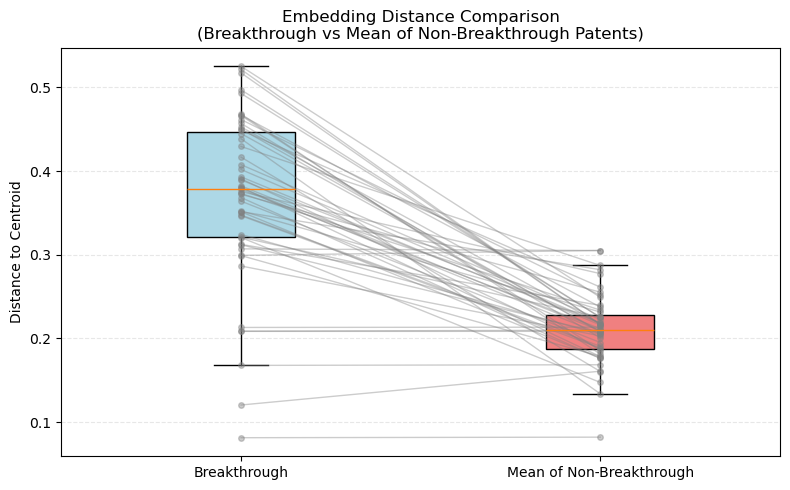

In [ ]:
# Assume these are your paired arrays (50 pairs)
x1 = full_bt
x2 = mean_rest
n = len(x1)

# Set x positions for each group
x_positions = [0, 1]

plt.figure(figsize=(8, 5))

# 1. Boxplots
data = [x1, x2]
box = plt.boxplot(data, positions=x_positions, widths=0.3, patch_artist=True, showfliers=False)

# Style the boxplots (optional)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# 2. Spaghetti lines
for i in range(n):
    plt.plot(x_positions, [x1[i], x2[i]], color='gray', alpha=0.4, linewidth=1, marker='o', markersize=4)

# Axis setup
plt.xticks(x_positions, ['Breakthrough', 'Mean of Non-Breakthrough'])
plt.ylabel('Distance to Centroid')
plt.title('Embedding Distance Comparison\n(Breakthrough vs Mean of Non-Breakthrough Patents)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

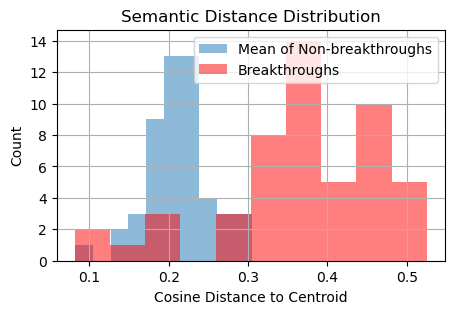

In [ ]:
# plot all distances
plt.figure(figsize=(5, 3))
plt.hist(mean_rest, bins=10, alpha=0.5, label='Mean of Non-breakthroughs')
plt.hist(full_bt, bins=10, alpha=0.5, color='red', label='Breakthroughs')

plt.xlabel("Cosine Distance to Centroid")
plt.ylabel("Count")
plt.title("Semantic Distance Distribution")
plt.legend()
plt.grid(True)
plt.show()

This analysis shows that **breakthrough patents are distinguishable from CPC-matched non-breakthrough patents in their embedding-based distance to centroid**, with a p < 1e-15, a large effect size of 1.67, and maximal statistical power (1.0). While the statistical results indicate a strong group-level distinction, the plot reveals substantial overlap between the two groups, suggesting that this separation may hold primarily at the group level within CPC classes. This raises concern about using a model trained for CPC classification purposes to assess innovation impact, as the semantic separation captured by the embeddings may reflect CPC structure more than true novelty.